In [1]:
import os,time,sys
import matplotlib.pyplot as plt 
import numpy as np
from charon import propa
from charon import profile
import charon.physicsconstants as PC
pc = PC.PhysicsConstants()
from Spectra_functions import Spectra_generator, Spectra_interpolation, Flux_generator, J_interpolation, Flux_interpolation, Signal_PDF, Background_PDF
from ipynb.fs.full.func_plot_histo import plot_projections

In [2]:
sys.path.append("/home/dvaldenaire/Python/Analysis/DMfit/DMfit")
from modeling import PdfBase, Model, Parameter
from data_DM import DataSet
from llh import LikelihoodRatioTest

Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5
Initial Flux Loading: /usr/local/lib/python3.10/dist-packages/charon-0.1.0-py3.10.egg/charon/data/SpectraEW.hdf5


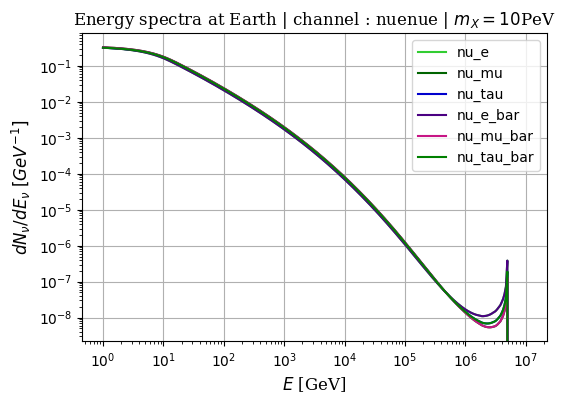

In [3]:
Reco_rate_NFW = Signal_PDF(mass=1e7, channel='nuenue',process='decay',galactic_profile=profile.NFW, extrapolation=True)

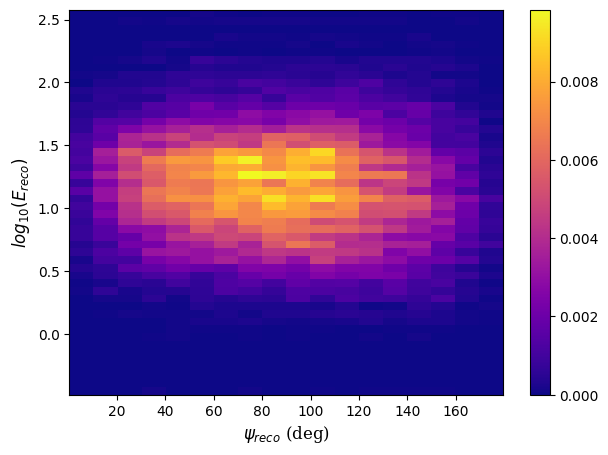

In [4]:
Background = Background_PDF(oversample=True, hist=True, bins=[18,50], density=True)

In [5]:
SignalPDF = PdfBase(Reco_rate_NFW.flatten()/np.sum(Reco_rate_NFW), name='Signal PDF')

In [6]:
BackgndPDF = PdfBase((Background[0].flatten())/np.sum(Background[0]), name='background')

In [7]:
dm_H1 = Parameter(value=0., limits=(0,1), fixed=False, name='dm_H1')
dm_H0 = Parameter(value=0., limits=(0,1), fixed=True, name='dm_H0')

In [8]:
modelH1 = dm_H1*SignalPDF + (1-dm_H1)*BackgndPDF
modelH0 = dm_H0*SignalPDF + (1-dm_H0)*BackgndPDF

Parameter dm_H1 already exists in the model, it won't be added again
Parameter dm_H0 already exists in the model, it won't be added again


In [10]:
ds = DataSet()
Background_sample = Background_PDF(oversample=True, hist=False, bins=None, density=None)

In [11]:
ksi = np.arange(0.,0.005,0.0001)

signal_frac_sample = []
for i,s in enumerate(ksi):
    signal_fraction = []
    for j in range(200):
        pseudo_data = (1-s)*BackgndPDF + s*SignalPDF
        ds.asimov(len(Background_sample), pseudo_data)
        lr = LikelihoodRatioTest(model = modelH1, null_model = modelH0)
        lr.data = ds #inject data in the likelihood model
        lr.fit('H1')
        lr.fit('H0')
        signal_fraction.append(lr.models['H1'].parameters['dm_H1'].value)
    signal_frac_sample.append(signal_fraction)

/home/dvaldenaire/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/home/dvaldenaire/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [26]:
mean, percentile68, percentile95, std = [],[],[],[]
for i in range(len(signal_frac_sample)):
    mean.append(np.mean(signal_frac_sample[i]))
    percentile68.append(np.percentile(signal_frac_sample[i],68.27))
    percentile95.append(np.percentile(signal_frac_sample[i],95.45))
    std.append(np.std(signal_frac_sample[i]))

In [27]:
low68 = [1-i for i in percentile68]
low95 = [1-i for i in percentile95]

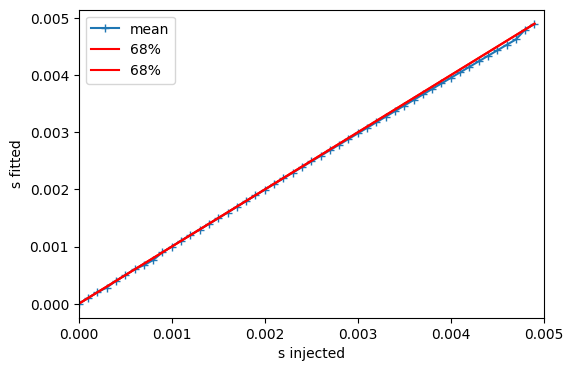

In [40]:
plt.figure(figsize=(6,4))
plt.plot(ksi,mean,marker='+',label='mean')
#plt.plot(ksi,percentile68,'k-')
plt.plot(ksi,ksi+std,'r-', label='68%')
plt.plot(ksi,ksi-std,'r-', label='68%')
#plt.plot(ksi,percentile95,'b-')
plt.xlim(0,0.005)
plt.xlabel('s injected')
plt.ylabel('s fitted')
plt.legend()
#plt.fill_between(ksi, low68, percentile68, alpha=0.3, color='green')
#plt.fill_between(mean, low95, percentile95, alpha=0.8, color='green')